In [ ]:
%load_ext autoreload
%autoreload 2

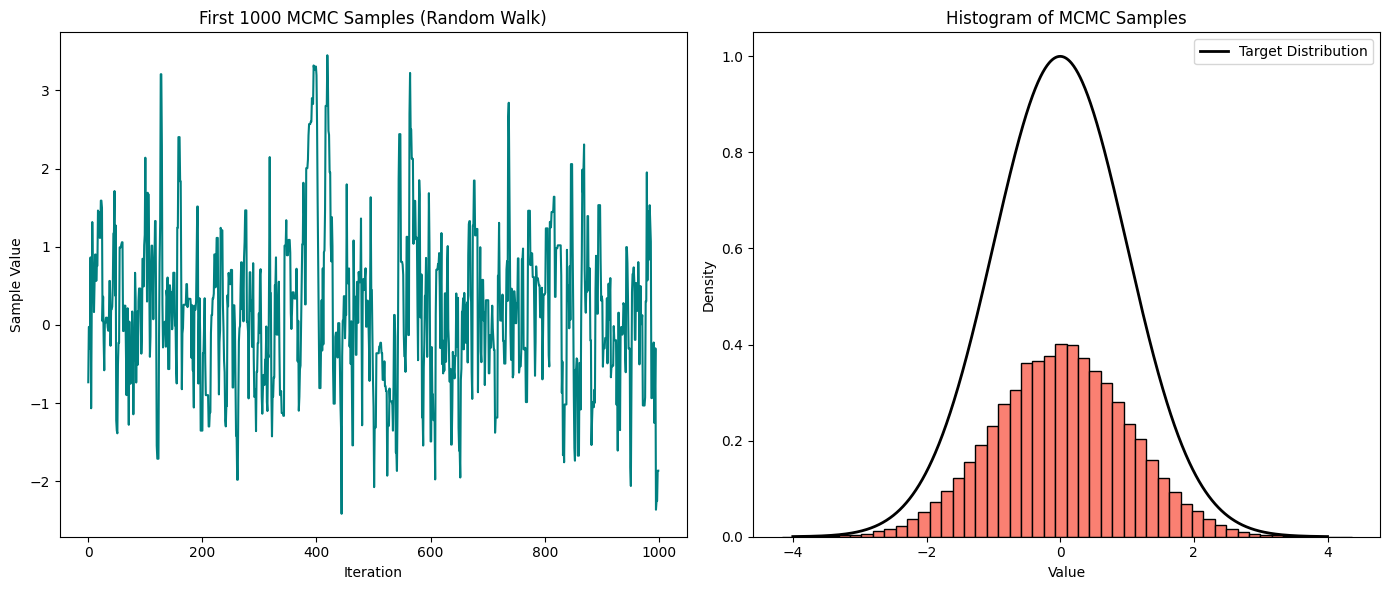

Estimated Mean (MCMC): 0.0165
Estimated Std Dev (MCMC): 1.0081


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Target distribution: Standard normal PDF (up to a constant factor)
def target_distribution(x):
    return np.exp(-0.5 * x**2)

# Metropolis-Hastings algorithm
n_samples = 100_000
samples = []
x_current = 0  # Start at 0

for _ in range(n_samples):
    x_proposed = x_current + np.random.normal(0, 1)  # Proposal step
    acceptance_ratio = target_distribution(x_proposed) / target_distribution(x_current)

    if np.random.rand() < acceptance_ratio:
        x_current = x_proposed  # Accept the proposal
    samples.append(x_current)

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(samples[:1000], color='teal')
plt.title('First 1000 MCMC Samples (Random Walk)')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')

plt.subplot(1, 2, 2)
plt.hist(samples, bins=50, color='salmon', edgecolor='black', density=True)
x = np.linspace(-4, 4, 1000)
plt.plot(x, target_distribution(x), color='black', linewidth=2, label='Target Distribution')
plt.title('Histogram of MCMC Samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Estimate mean and standard deviation
mean_mcmc = np.mean(samples)
std_mcmc = np.std(samples)

print(f"Estimated Mean (MCMC): {mean_mcmc:.4f}")
print(f"Estimated Std Dev (MCMC): {std_mcmc:.4f}")

# Quantile function

In [2]:
import numpy as np

data = [10, 20, 30, 40, 50]

# Default method (linear interpolation)
q25_default = np.quantile(data, 0.25)
q50_default = np.quantile(data, 0.5)

# Different interpolation options
q25_lower = np.quantile(data, 0.25, method='lower')
q25_higher = np.quantile(data, 0.25, method='higher')
q25_nearest = np.quantile(data, 0.25, method='nearest')
q25_midpoint = np.quantile(data, 0.25, method='midpoint')

print(f"Default (linear interpolation) 25th percentile: {q25_default}")
print(f"Lower 25th percentile: {q25_lower}")
print(f"Higher 25th percentile: {q25_higher}")
print(f"Nearest 25th percentile: {q25_nearest}")
print(f"Midpoint 25th percentile: {q25_midpoint}")

Default (linear interpolation) 25th percentile: 20.0
Lower 25th percentile: 20
Higher 25th percentile: 20
Nearest 25th percentile: 20
Midpoint 25th percentile: 20.0


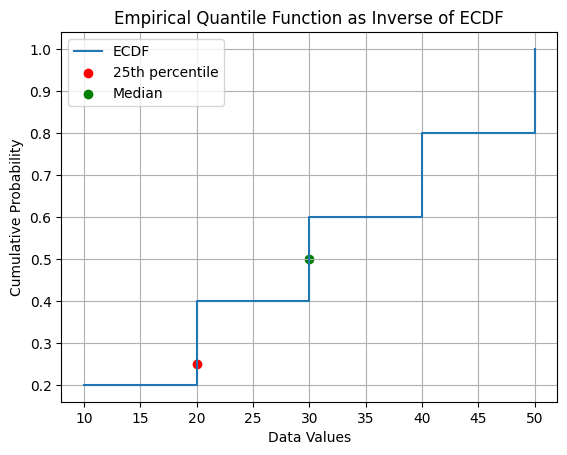

In [3]:
import matplotlib.pyplot as plt

# Empirical CDF
sorted_data = np.sort(data)
ecdf = np.arange(1, len(data) + 1) / len(data)

# Plot
plt.step(sorted_data, ecdf, where="post", label="ECDF")
plt.scatter(q25_default, 0.25, color='red', label="25th percentile")
plt.scatter(q50_default, 0.5, color='green', label="Median")

plt.xlabel("Data Values")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.title("Empirical Quantile Function as Inverse of ECDF")
plt.show()

# Difference-in-Difference


,Parameter,Value
0,Number of users,1000
1,Base watch time,30
2,Base difference,20
3,Lift due to treatment,5


period,group,post,pre
0,control,31.416725,30.386641
1,treatment,54.625616,50.116684


,Metric,Value
0,Pre-Test Difference,19.730043
1,Post-Test Difference,23.208891
2,Difference-in-Differences Estimate,3.478848


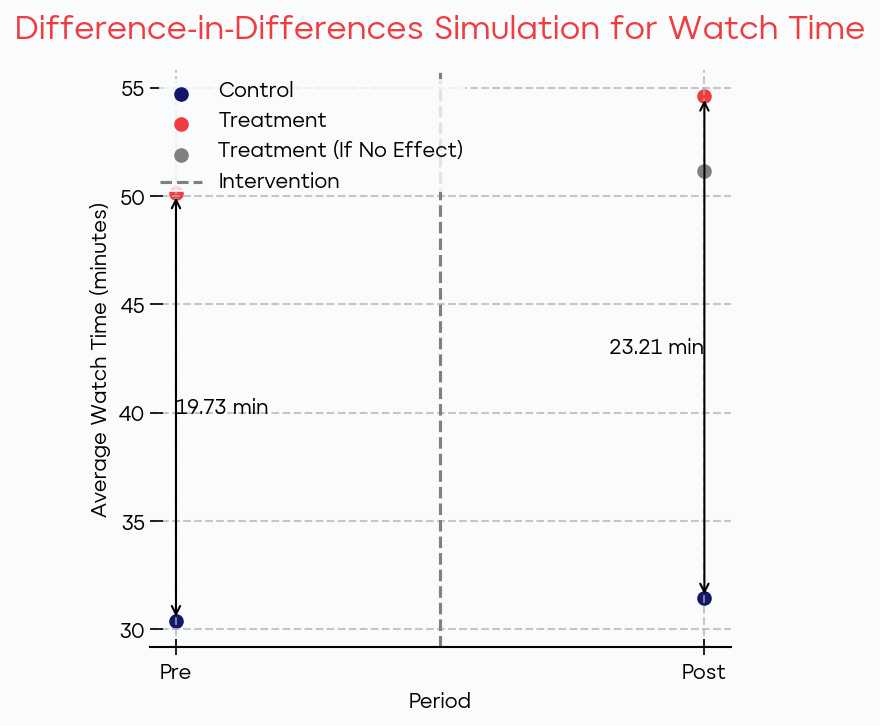

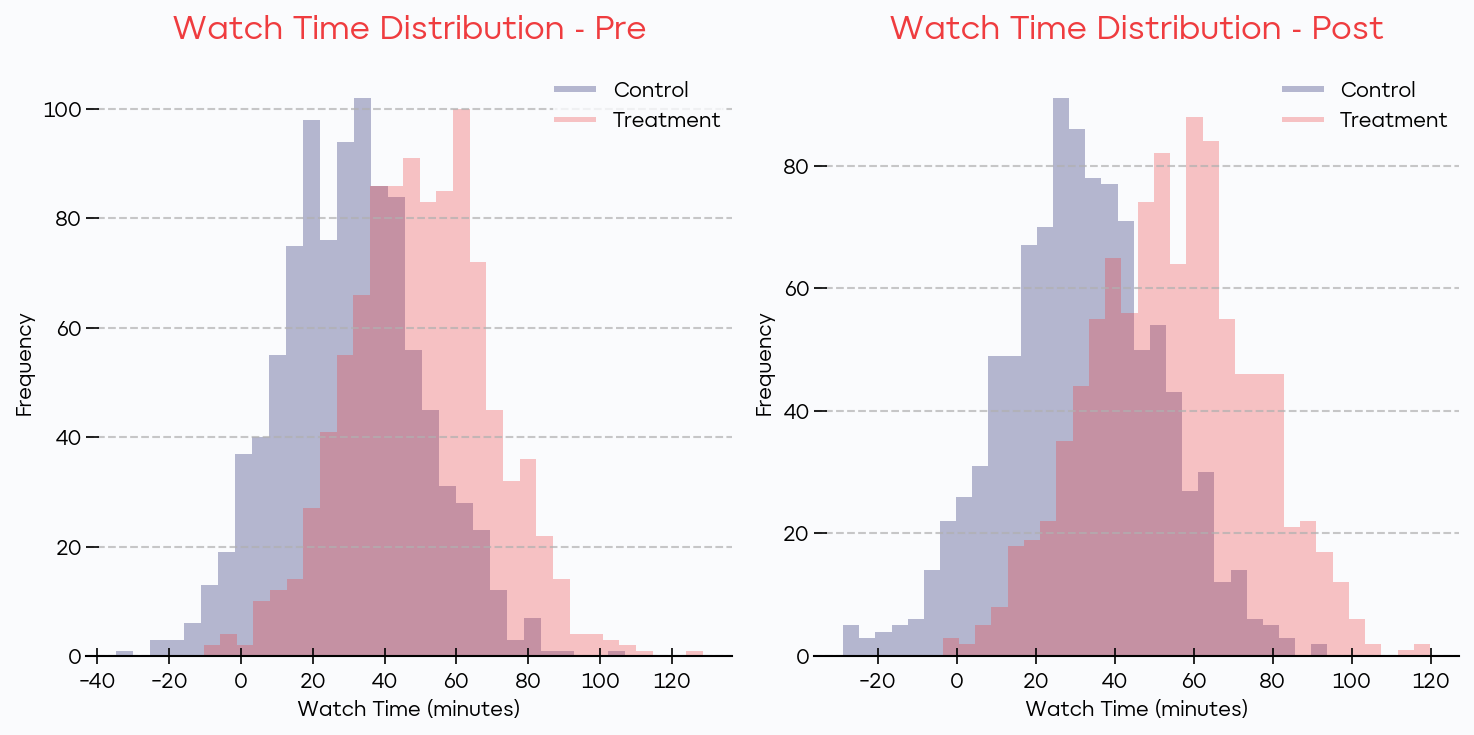

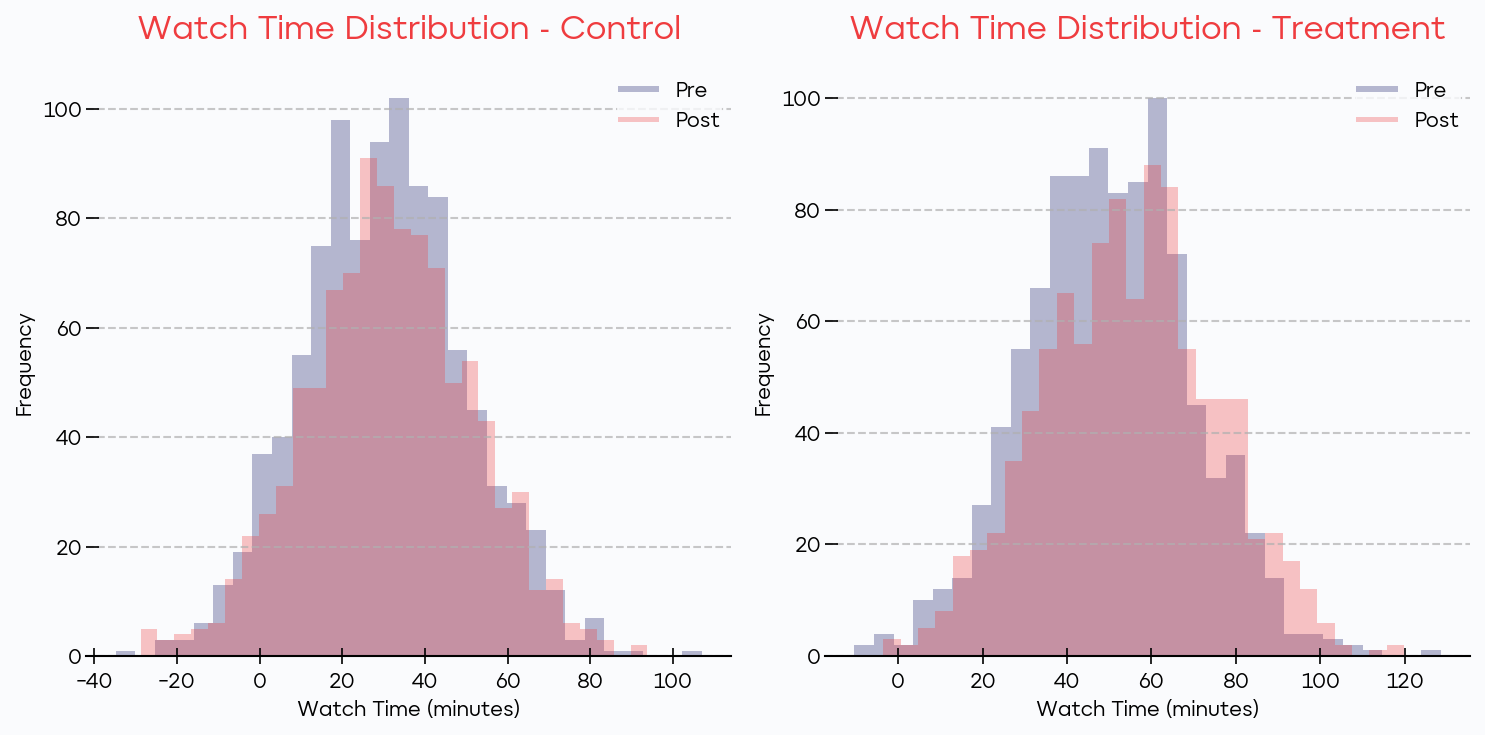

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.visualization.mpl_style import set_mpl_style
set_mpl_style()

# Parameters
n = 1000  # Number of users per group per period
base_watch_time = 30  # Average watch time in minutes
lift_due_to_treatment = 5  # Increase in watch time due to treatment

noise = 20
base_difference = noise



# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
def generate_data(n, base_time, lift=0.0):
    return np.random.normal(base_time + lift, noise, n)

# Control group
control_pre = generate_data(n, base_watch_time)
control_post = generate_data(n, base_watch_time)

# Treatment group
# Pre-intervention (no effect yet)
treatment_pre = generate_data(n, base_watch_time, base_difference)
# Post-intervention (with treatment effect)
treatment_post = generate_data(n, base_watch_time, lift_due_to_treatment + base_difference)

# Create DataFrame
data = pd.DataFrame({
    'group': ['control'] * (2 * n) + ['treatment'] * (2 * n),
    'period': ['pre'] * n + ['post'] * n + ['pre'] * n + ['post'] * n,
    'watch_time': np.concatenate([control_pre, control_post, treatment_pre, treatment_post])
})

# Calculate average watch time
watch_time_means = data.groupby(['group', 'period'])['watch_time'].mean().unstack()

# Expected treatment post if no effect
expected_treatment_post_no_effect = watch_time_means.loc['treatment', 'pre'] + (watch_time_means.loc['control', 'post'] - watch_time_means.loc['control', 'pre'])

# Difference-in-Differences calculation
pre_diff = watch_time_means.loc['treatment', 'pre'] - watch_time_means.loc['control', 'pre']
post_diff = watch_time_means.loc['treatment', 'post'] - watch_time_means.loc['control', 'post']
did_estimate = post_diff - pre_diff

# Store input parameters in a DataFrame
input_params = pd.DataFrame({
    'Parameter': ['Number of users', 'Base watch time', 'Base difference', 'Lift due to treatment'],
    'Value': [n, base_watch_time, base_difference, lift_due_to_treatment]
})

# Store watch time means in a DataFrame
watch_time_means_df = watch_time_means.reset_index()

# Store results in a DataFrame
results = pd.DataFrame({
    'Metric': ['Pre-Test Difference', 'Post-Test Difference', 'Difference-in-Differences Estimate'],
    'Value': [pre_diff, post_diff, did_estimate]
})

# Print input parameters, watch time means, and results
display(input_params)
display(watch_time_means_df)
display(results)

# Plot results
plt.figure(figsize=(5, 5))
x = ['Pre', 'Post']
plt.scatter(x, [watch_time_means.loc['control', 'pre'], watch_time_means.loc['control', 'post']], label='Control', marker='o')
plt.scatter(x, [watch_time_means.loc['treatment', 'pre'], watch_time_means.loc['treatment', 'post']], label='Treatment', marker='o')
plt.scatter('Post', expected_treatment_post_no_effect, color='grey', label='Treatment (If No Effect)', marker='o')
plt.axvline(0.5, color='gray', linestyle='--', label='Intervention')

# Add double-sided arrows showing differences
plt.annotate('', xy=('Pre', watch_time_means.loc['treatment', 'pre']), xycoords='data',
             xytext=('Pre', watch_time_means.loc['control', 'pre']), textcoords='data',
             arrowprops=dict(arrowstyle='<->'))
plt.text('Pre', (watch_time_means.loc['treatment', 'pre'] + watch_time_means.loc['control', 'pre']) / 2,
         f'{pre_diff:.2f} min', ha='left', va='center')

plt.annotate('', xy=('Post', watch_time_means.loc['treatment', 'post']), xycoords='data',
             xytext=('Post', watch_time_means.loc['control', 'post']), textcoords='data',
             arrowprops=dict(arrowstyle='<->'))
plt.text('Post', (watch_time_means.loc['treatment', 'post'] + watch_time_means.loc['control', 'post']) / 2,
         f'{post_diff:.2f} min', ha='right', va='center')

plt.xlabel('Period')
plt.ylabel('Average Watch Time (minutes)')
plt.title('Difference-in-Differences Simulation for Watch Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot combined histograms
plt.figure(figsize=(10, 5))

# Pre-intervention histogram
ALPHA = 0.3
plt.subplot(1, 2, 1)
plt.hist(control_pre, bins=30, alpha=ALPHA, label='Control')
plt.hist(treatment_pre, bins=30, alpha=ALPHA, label='Treatment')
plt.title('Watch Time Distribution - Pre')
plt.xlabel('Watch Time (minutes)')
plt.ylabel('Frequency')
plt.legend()

# Post-intervention histogram
plt.subplot(1, 2, 2)
plt.hist(control_post, bins=30, alpha=ALPHA, label='Control')
plt.hist(treatment_post, bins=30, alpha=ALPHA, label='Treatment')
plt.title('Watch Time Distribution - Post')
plt.xlabel('Watch Time (minutes)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Plot combined histograms
plt.figure(figsize=(10, 5))

# Pre-intervention histogram
plt.subplot(1, 2, 1)
plt.hist(control_pre, bins=30, alpha=ALPHA, label='Pre')
plt.hist(control_post, bins=30, alpha=ALPHA, label='Post')
plt.title('Watch Time Distribution - Control')
plt.xlabel('Watch Time (minutes)')
plt.ylabel('Frequency')
plt.legend()

# Post-intervention histogram
plt.subplot(1, 2, 2)
plt.hist(treatment_pre, bins=30, alpha=ALPHA, label='Pre')
plt.hist(treatment_post, bins=30, alpha=ALPHA, label='Post')
plt.title('Watch Time Distribution - Treatment')
plt.xlabel('Watch Time (minutes)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()